## Overview
In this project, I've engineered an adaptive machine learning algorithm that undergoes biannual recalibration to select the most accurate model for sector-based investment strategies. To counteract the pitfalls of over-forecasting, the algorithm employs a custom loss function that penalizes overpredictions. It comprehensively integrates a diverse range of financial indicators, including equity, debt, commodities, and market volatility. To enhance computational efficiency and model precision, I employed Principal Component Analysis for feature reduction. The model's robustness was substantiated through a 15-year backtest, during which it outperformed the SPY index by an estimated 91.85%. The finalized, vetted model has been encapsulated in a real-time dashboard.

## Business Understanding: Adaptive Sector Selection
The mercurial landscape of the financial markets warrent strategies that are dynamic and adapative, but even strategies like sector rotation often fall short due to their reliance on static heuristics. This project mitigates such limitations by employing a machine learning-driven "model of models" framework. This ensemble of algorithms undergoes biannual retraining and evaluation. The best-performing model is then selected for the next six-month cycle, ensuring the investment strategy continually adapts to current market conditions.

Once the leading model is identified, it selects the investment sector based on its predicted mean returns, specifically targeting the sector forecasted to yield the highest return. This dynamic, model-driven sector selection aims to optimize investment outcomes by leveraging timely and precise machine learning predictions.

The strategy is then tested via a 15-year backtest, offering empirical validation of its sector-based approach. Thus, the framework's utility manifests in its ability to not only adapt to market vicissitudes but also pinpoint the most promising sectors for investment based on forecasts.

---

## 3. Backtest and Present-Day Model Usage
This notebook goes through the backtesting process and outlines how the model can be used in present-day.

The below are the necessary imports and file read-ins.

In [24]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data Visulization
import matplotlib.pyplot as plt
import seaborn as sns

# Custom modules and functions
from workflow.tools.utils import read_file, get_sectors, set_plot_style

# Custom portfolio tools
import workflow.tools.portfolio.optimize as opt
from workflow.tools.portfolio.backtest import get_transaction_costs, reindex_costs, backtest_portfolios
from workflow.tools.portfolio.prune import prune_recommended_portfolios
from workflow.tools.portfolio.metrics import Metrics

# Custom model / metrics tools
from workflow.tools.model_selection import ts_cross_val_score, arimax_cross_val_score, overunder_error

# sklearn pipeline, PCA, and standardization
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# sklearn models
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# ARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# XGBoost Model
from xgboost import XGBRegressor

# Progress bar for loops
from tqdm.auto import tqdm

# Suppress warnings
from warnings import filterwarnings

filterwarnings("ignore")
set_plot_style()

df = read_file("master_df", index_col=0)
sectors = get_sectors()
snp_log_returns = read_file("snp_log_returns", index_col=0)
stocks_by_sector = read_file("stocks_by_sector", index_col=0)

ms_allocations = read_file("ms_allocations", index_col=0)
mv_allocations = read_file("mv_allocations", index_col=0)
rp_allocations = read_file("rp_allocations", index_col=0)

One more thing before we conduct the backtest—we need to account for transaction costs. For the sake of simplicity, we'll set a fixed transaction cost rate of 0.2% per trade. Real world scenarios would call for the accounting of tax costs, and possibly varying cost rates. However, the degrees to which we must do this in real life depends on the specific brokers we are working with.

I account for transaction costs as per:

$$C_{i} = r \times \left|\Delta{w_{i}}\right|$$

Where $C_{i}$ is the transaction cost for the $i^{\text{th}}$ rebalancing period, $r$ is the cost rate, representing the proportion of the traded volume that is incurred as a transaction cost, and $\left|\Delta{w_{i}}\right|$ is the absolute change in asset weights between the $i^{\text{th}}$ and $(i-1)^{\text{th}}$ period. This approach allows for costs to adjust based on changes in portfolio allocation, capturing not only the shifts in asset weights but also scales them with a rate that reflects the transaction costs as a fraction of the traded volume:

### Transaction Costs

In [25]:
# Set a fixed transaction cost rate of 0.2%
transaction_costs = 0.002

# Calculate transaction costs for three different portfolio strategies: 
# Mean-Variance (mv), Risk Parity (rp), and Mean-Squared (ms).
# The get_transaction_costs function returns the transaction costs Series for each portfolio.
ms_costs, mv_costs, rp_costs = get_transaction_costs(
    ms_allocations, mv_allocations, rp_allocations, cost=transaction_costs
)

### Backtesting

With transaction costs computed, we can now get to the backtest. The backtest occurs from November 20<sup>th</sup>, 2007 to September 11<sup>th</sup>, 2023, offering a 16-year window view of how our framework would have played out net costs.

In [26]:
# Backtest portfolios for MS, MV, and RP strategies using the specified allocations
ms_port_rets, mv_port_rets, rp_port_rets = backtest_portfolios(
    ms_allocations, 
    mv_allocations, 
    rp_allocations, 
    constituent_returns=snp_log_returns
)

# Reindex costs to align with portfolio returns
ms_port_rets -= reindex_costs(ms_costs, ms_port_rets)
mv_port_rets -= reindex_costs(mv_costs, mv_port_rets)
rp_port_rets -= reindex_costs(rp_costs, rp_port_rets)

# Calculate the equal-weighted portfolio returns by taking the mean of constituent returns
ew_port_rets = snp_log_returns.sum(axis=1) / len(snp_log_returns.columns)

# Reindex the equal-weighted portfolio returns to match the other portfolio returns' index
ew_port_rets = ew_port_rets.reindex(ms_port_rets.index)

# Set the return at the earliest date to 0 for consistency
ew_port_rets.loc[ew_port_rets.index.min()] = 0

# Concatenate the portfolio returns (ew_port_rets, ms_port_rets, mv_port_rets, rp_port_rets) horizontally
port_rets = pd.concat([ew_port_rets, ms_port_rets, mv_port_rets, rp_port_rets], axis=1)

# Rename the columns to describe each portfolio strategy
port_rets.columns = ["ONE_OVER_N", "MAX_SHARPE", "MIN_VAR", "RISK_PARITY"]

# Create an instance of the Metrics class
portfolio_metrics = Metrics()

# Calculate portfolio metrics (e.g., mean return, volatility, Sharpe ratio) using the Metrics class
port_comparison = portfolio_metrics.calculate(port_rets)

In [27]:
port_comparison

,Sharpe Ratio,Cumulative Return,Annualized Return,Annualized Volatility
MAX_SHARPE,0.457681,2.237032,0.141109,0.308314
RISK_PARITY,0.370835,1.588835,0.100222,0.270260
ONE_OVER_N,0.415299,1.449550,0.091436,0.220169
MIN_VAR,0.356258,1.205543,0.076044,0.213453


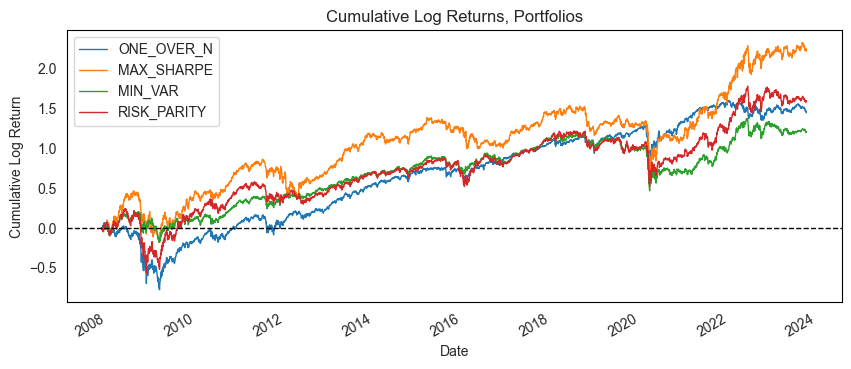

In [28]:
# Plot cumulative returns of each portfolio
port_rets.cumsum().plot(figsize=(10, 4), grid=False)
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title("Cumulative Log Returns, Portfolios")
plt.ylabel("Cumulative Log Return")
plt.show()

First I backtest the three mean-variance portfolio optimization strategies, weighed against a naive Equal-Weight porfolio. The Maximum Sharpe portfolio led the pack with an annualized return of 14.77% and a Sharpe Ratio of 0.481, albeit with a higher annualized volatility of 30.73%.

The Risk Parity portfolio, designed for balanced risk contribution from each asset, yielded an annualized return of 10.33% with a Sharpe Ratio of 0.380. One-Over-N, which allocates equally across assets, registered a Sharpe Ratio of 0.430 and an annualized return of 9.50%. The Minimum Variance portfolio, geared towards minimizing risk, had the lowest annualized return of 8.08% and a Sharpe Ratio of 0.375.

In [29]:
# Compare the best portfolio with sector returns
sector_metrics = Metrics()

best_portfolio = portfolio_metrics.metrics['Cumulative Return'].idxmax()
sector_returns_reindexed = df[sectors].reindex(port_rets.index).copy()
sector_returns_reindexed.loc[sector_returns_reindexed.index.min()] = 0
sector_comparison = pd.concat([port_rets[best_portfolio], sector_returns_reindexed], axis=1)
sector_comparison_t5 = sector_metrics.calculate(sector_comparison)[:5]

sector_comparison_t5

,Sharpe Ratio,Cumulative Return,Annualized Return,Annualized Volatility
MAX_SHARPE,0.457681,2.237032,0.141109,0.308314
INFORMATION_TECHNOLOGY,0.488811,2.000981,0.126220,0.258218
HEALTH_CARE,0.545716,1.692889,0.106785,0.195680
INDUSTRIALS,0.445560,1.692338,0.106751,0.239588
CONSUMER_DISCRETIONARY,0.409283,1.675232,0.105672,0.258187


In the second leg of the backtest, I compared the performance of the Maximum Sharpe portfolio against the top four best-performing sectors.

The Information Technology sector came close to the Maximum Sharpe portfolio with an annualized return of 12.62% and a Sharpe Ratio of 0.49. Healthcare outperformed all in terms of risk-adjusted returns, boasting a Sharpe Ratio of 0.546, although it had a lower annualized return of 10.68%. Consumer Discretionary and Industrials also fared well with annualized returns above 10% and Sharpe Ratios around 0.41 and 0.45, respectively.

In [30]:
# Compare best portfolio to S&P 500
SPY_metrics = Metrics()

# Load SPY prices
SPY_log_rets = read_file("spy_log_returns", "data", index_col="Date")
SPY_log_rets.columns = ["SPY"]

# Combine SPY returns and best portfolo returns into a dataframe for comparison
spy_bt = pd.concat([port_rets[best_portfolio], SPY_log_rets], axis=1)

# Compare
spy_comparison = SPY_metrics.calculate(spy_bt)

spy_comparison

,Sharpe Ratio,Cumulative Return,Annualized Return,Annualized Volatility
MAX_SHARPE,0.457681,2.237032,0.141109,0.308314
SPY,0.332942,1.090190,0.068768,0.206546


Lastly, the Maximum Sharpe portfolio was juxtaposed against the S&P 500 index (SPY) for a final litmus test. The Maximum Sharpe portfolio outperformed SPY, delivering an annualized return of 14.11% compared to SPY's 6.88%. Additionally, the Maximum Sharpe portfolio had a higher Sharpe Ratio of 0.46, compared to SPY's 0.33.

While the Maximum Sharpe portfolio exhibited a higher annualized volatility of 30.83% against SPY's 20.65%, the elevated risk was well-compensated by superior returns and a better risk-adjusted performance.

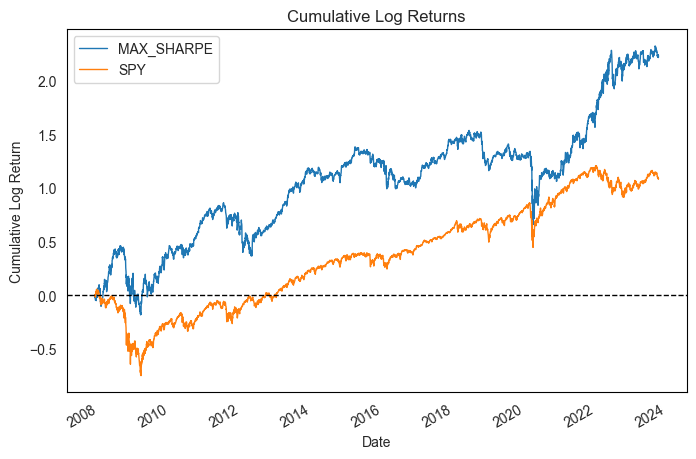

In [31]:
# Plot equity curve of SPY and Maximum Sharpe
spy_bt.cumsum().plot(figsize=(8, (8*(2/3))), grid=False)
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title("Cumulative Log Returns")
plt.ylabel("Cumulative Log Return")
plt.show()

Let's see the annualized alpha generated by the algorithm over time:

In [32]:
(-spy_bt.cumsum().diff(axis=1)).resample("Y").mean().mean()

MAX_SHARPE         NaN
SPY           0.670373
dtype: float64

67% - not shabby at all!

Now that we have the backtest, we need to be able to use the model **today**. So, let's code that up and see what it's telling us to invest in.

### Present-Day Model Usage

To utilize the 'model of models' framework presented in this project, we have to do it a bit differently from what was done in the backtest. In the backtest, the entire feature dataframe was shifted forward by 126 days. This meant that we lost the *most recent 126 days of feature data*. This was fine for the backtest, which primarily aimed to showcase the strategy's broader performance across 16 years, but to use the model *today*, we need that last bit of data. We also need to take the past *year* of data as opposed to the past half year. I'll showcase why.

Let's denote today as $t$, feature data as $I$, and target data as $O$, our model training process follows the approach below:

| Description | Variable | Start | End |
| :-: | :-: | :-: | :-: |
| Training Input | `X_train` | $I_{t-252}$ | $I_{t-126}$ |
| Training Output | `y_train` | $O_{t-126}$ | $O_{t}$ |
| Real-time Input | `X_test` | $I_{t-126}$ | $I_{t}$ |
| Real-time Output | - | $O_{t}$ | $O_{t+126}$ |

In other words, we train the model to use the past half year to predict the next half year, and we need that last bit of data to make the forecast for the next half year; this also explains why we're concerned with the past year of data—because we didn't shift the feature dataset for real-time model usage. Also note that won't have a `y_test` this time, as we don't have future data available to us today. The 'model of models' picks the best model to use based on cross-validation within the training data, so this won't be a problem.

In [33]:
# Define number of trading days in a year and forecast period
trading_days = 252
forecast = int(trading_days / 2)

# Separate the combined dataframe into targets (sector average returns) and features
# Take only the past year's data
y = df[sectors].iloc[-trading_days:]
X = df[df.columns[~df.columns.isin(sectors)]].iloc[-trading_days:]

X.shape, y.shape

((252, 109), (252, 11))

In [34]:
# Intialize scaler, PCA, and models
scaler = StandardScaler()
pca = PCA(n_components=.8, random_state=42)

all_sklearn_models = {
    'ElasticNet_B': make_pipeline(scaler, pca, ElasticNet(random_state=42)),
    'RandomForest_B': make_pipeline(scaler, pca, RandomForestRegressor(random_state=42)),
    'GradientBoost_B': make_pipeline(scaler, pca, GradientBoostingRegressor(random_state=42)),
    'XGBoost_B': make_pipeline(scaler, pca, XGBRegressor(random_state=42)),
    'ElasticNet_T': make_pipeline(scaler, pca, ElasticNet(alpha=1, l1_ratio=0.5, random_state=42)),
    'SVR_T': make_pipeline(scaler, pca, SVR(kernel='rbf', C=1, gamma='auto')),
    'RandomForest_T': make_pipeline(scaler, pca, RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)),
    'GradientBoost_T': make_pipeline(scaler, pca, GradientBoostingRegressor(n_estimators=100, random_state=42)),
    'XGBoost_T': make_pipeline(scaler, pca, XGBRegressor(n_estimators=100, random_state=42)),
}

In [35]:
# Initialize a pipeline for data preprocessing: Standardization followed by PCA
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=.8, random_state=42))

# Define ARIMAX model orders for ARIMA and seasonal components
order = (1, 0, 1)

# Initialize DataFrames to store mean over-under loss (OUL) and model predictions
mean_oues = pd.DataFrame()
predictions = pd.DataFrame()

# Loop through each sector for analysis
for sector in tqdm(sectors):
    
    # Use the most recent data for training and testing
    X_train = X.iloc[:forecast]
    y_train = y[sector][forecast:]
    X_test = X.iloc[forecast:]

    # Loop through each machine learning model
    for name, model in all_sklearn_models.items():
        
        # Compute mean OUL using time-series cross-validation
        mean_oue = np.mean(
            ts_cross_val_score(
                model,
                X_train,
                y_train,
                cv=2,
                scorer=overunder_error,
                overpred_penalty=2,
                underpred_penalty=0
            )
        )
        
        # Store the mean OUL for each model and sector
        mean_oues.loc[name, sector] = mean_oue
        
        # Fit the model and make predictions
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        
        # Store the mean predicted value for each model and sector
        predictions.loc[name, sector] = np.mean(y_hat)

    # Apply PCA transformation to the training and testing feature sets
    X_train_pca = pca_pipe.fit_transform(X_train)
    X_test_pca = pca_pipe.transform(X_test)

    # Compute mean OUL for the ARIMAX model using time-series cross-validation
    arimax_mean_oue = np.mean(
        arimax_cross_val_score(
            X_train,
            y_train,
            order=order,
            pca=pca_pipe,
            cv=2,
            scorer=overunder_error,
            overpred_penalty=2,
            underpred_penalty=0
        )
    )
    
    # Fit the ARIMAX model and make forecasts
    arimax = SARIMAX(endog=y_train, exog=X_train_pca, order=order).fit()
    forecast_result = arimax.get_forecast(steps=(len(X_test_pca)), exog=X_test_pca)
    arimax_y_hat = forecast_result.predicted_mean
    
    # Store the mean OUL and predicted values for ARIMAX model
    mean_oues.loc["ARIMAX", sector] = arimax_mean_oue
    predictions.loc["ARIMAX", sector] = np.mean(arimax_y_hat)

100%|██████████| 11/11 [00:43<00:00,  3.93s/it]


In [36]:
# Identify the best model and the sector it chose
best_model = mean_oues.mean(axis=1).idxmin()
chosen_sector = predictions.loc[best_model].idxmax()

best_model, chosen_sector

('SVR_T', 'MATERIALS')

In [37]:
# Filter stocks belonging to the chosen sector
chosen_stocks = stocks_by_sector[stocks_by_sector["GICS Sector"] == chosen_sector]
# Further filter stocks that are present in our returns dataframe
chosen_stocks = chosen_stocks[chosen_stocks["Symbol"].isin(snp_log_returns.columns)]["Symbol"]
# Convert to list
chosen_stocks = chosen_stocks.to_list()

# Count the number of chosen stocks
n_stocks = len(chosen_stocks)

# Initialize weights for portfolio optimization
initial_weights = np.array([1/n_stocks] * n_stocks)
# Extract returns of the chosen stocks for the forecasting period
returns = snp_log_returns[chosen_stocks][-forecast:]

# Compute Maximum Sharpe portfolio
ms_portfolio = pd.Series(opt.max_sharpe_opt(initial_weights, returns)[0], index=chosen_stocks)
# Compute Minimum Variance portfolio
mv_portfolio = pd.Series(opt.min_var_opt(initial_weights, returns)[0], index=chosen_stocks)
# Compute Risk Parity portfolio
rp_portfolio = pd.Series(opt.risk_parity_opt(initial_weights, returns)[0], index=chosen_stocks)

# Prune portfolios based on a minimum weight threshold
ms_portfolio, mv_portfolio, rp_portfolio = prune_recommended_portfolios(
    ms_portfolio, mv_portfolio, rp_portfolio, min_weight_th=0.01
)

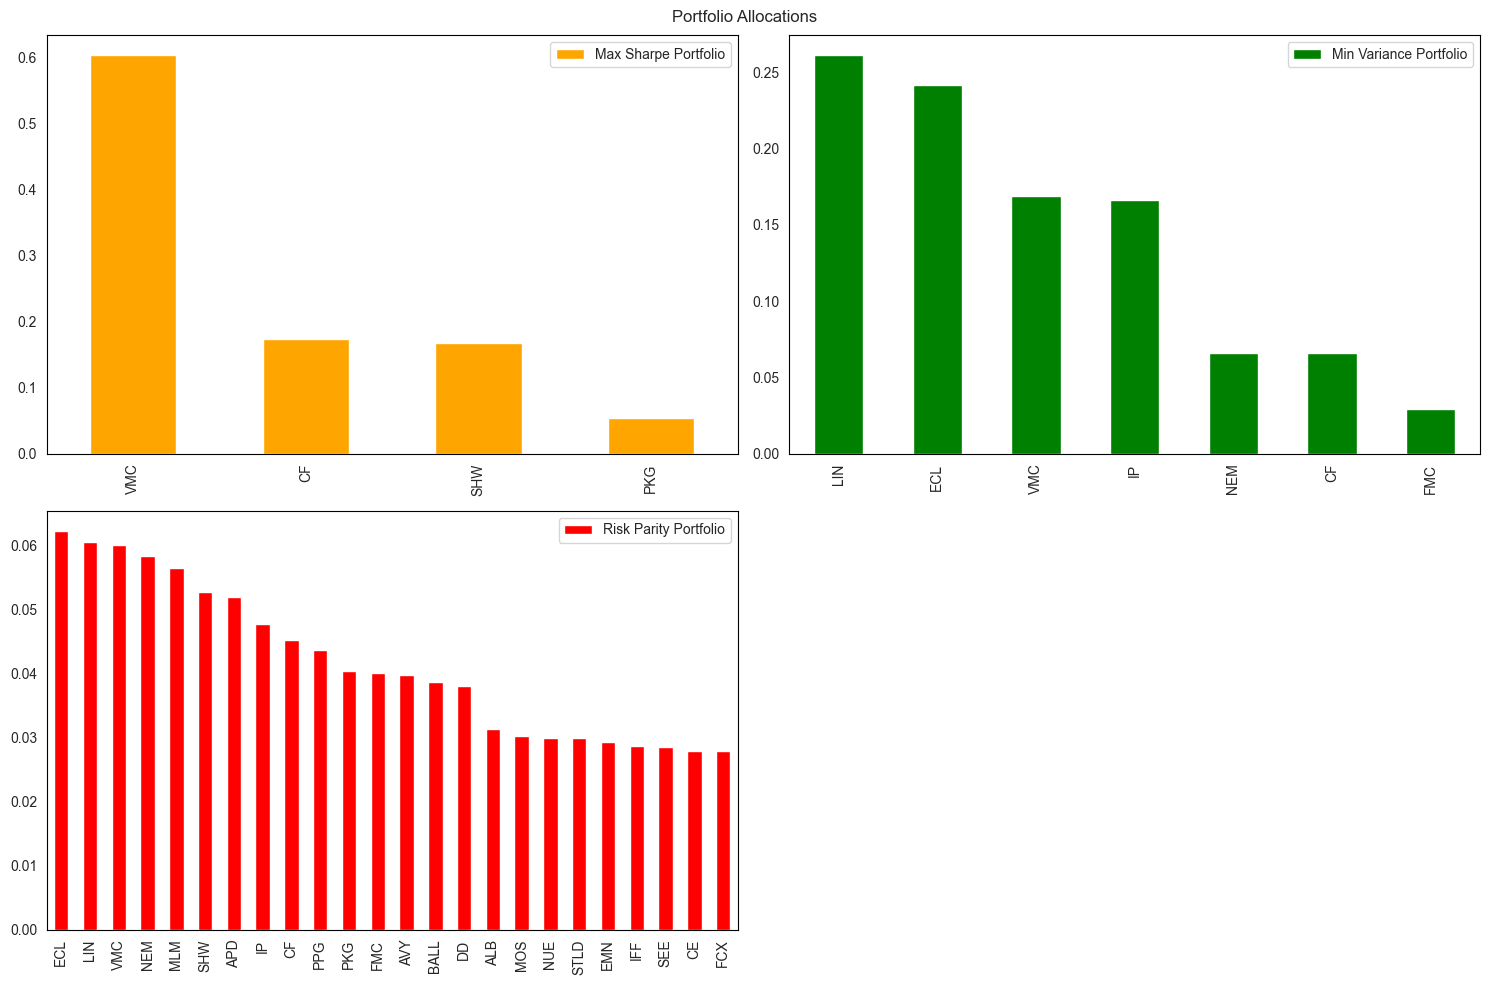

In [38]:
# Plot portfolio allocations
portfolios = [
    ms_portfolio.sort_values(ascending=False),
    mv_portfolio.sort_values(ascending=False),
    rp_portfolio.sort_values(ascending=False),
]

colors = ["orange", "green", "red"]

names = [
    "Max Sharpe Portfolio", 
    "Min Variance Portfolio",
    "Risk Parity Portfolio"
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Portfolio Allocations")
axes = axes.flatten()

for i, portfolio in enumerate(portfolios):
    portfolio.plot.bar(ax=axes[i], color=colors[i], grid=False)
    axes[i].legend([names[i]])

axes[-1].axis("off")
plt.tight_layout()

In [39]:
pd.DataFrame(portfolios[0].apply(lambda x: f"{x*100:,.1f}%"), columns=["Maximum Sharpe Portfolio"])

,Maximum Sharpe Portfolio
VMC,60.4%
CF,17.3%
SHW,16.8%
PKG,5.5%


In [40]:
r = opt.port_sharpe(ms_portfolio, returns[ms_portfolio.index])
s = opt.port_std(ms_portfolio, returns[ms_portfolio.index])

r

2.206479211705205

### Summary
The Maximum Sharpe Ratio strategy outperformed all individual sectors and the S&P 500 index in terms of both Sharpe ratio and cumulative return. However, this performance came with heightened volatility. Among sectors, Healthcare led in Sharpe ratio but was second to Technology in cumulative and annualized returns. Overall, the asset allocation strategies, particularly Maximum Sharpe Ratio, demonstrated their effectiveness in maximizing portfolio returns over a 16-year period.

### Conclusion

This work combines machine learning and portfolio optimization to construct a dynamic asset management framework. The architecture, a "Model of Models," undergoes a biannual recalibration, ensuring the methodology remains responsive to changing market conditions. The custom asymmetric loss function, designed to penalize overestimations, adds a safeguard against overexposure to risk. This is particularly crucial for long-only investment strategies, where mitigating downside risk is essential.

In terms of asset allocation, the Maximum Sharpe Ratio strategy surfaced as the most effective in generating the highest risk-adjusted returns. Although this approach led to higher portfolio volatility, it outperformed all individual sectors and the broad market, as represented by the S&P 500. The model's repeated selection of specific sectors like Energy and Information Technology could indicate its ability to latch onto persistent market trends, potentially providing an edge in long-term investment.

Transaction costs, often neglected in theoretical models, were incorporated here, providing a more realistic performance assessment. The inclusion of these costs did not significantly hamper the model's ability to outperform the market benchmark over a 16-year backtest.

In summary, the project offers a dynamic, adaptable, and robust framework for sector-based portfolio management. It not only adjusts to market conditions but also provides a built-in mechanism for risk control. The empirical results suggest that this approach could serve as a compelling alternative to traditional investment strategies, offering both adaptability and performance.


### Limitations

#### Data Constraints
The dataset, although expansive, has its limitations. One primary concern is the assumption of stationarity. While each feature was tested for this property, the very nature of financial markets implies that they can undergo fundamental changes, thereby violating the stationarity premise. The 16-year backtesting window also carries the risk of generalization, as it may encompass multiple market regimes, each with its unique characteristics. This polyregime environment could blur the lines of interpretability and generalizability, making it challenging to isolate the model's performance across distinct market conditions.

#### Modeling Caveats
In the realm of machine learning models, several pitfalls need addressing. Despite efforts to regularize, the risk of overfitting to the training data remains, particularly given the complex, high-dimensional nature of financial markets. The biannual recalibration, while designed to keep the model up-to-date, may not be agile enough to adapt to sudden market shifts. The custom asymmetric loss function is designed to mitigate the risk of overpredictions, but it's not a foolproof mechanism. The "Model of Models" architecture, although robust, could inadvertently be biased toward models that excel in specific market conditions but underperform in others, thereby lacking in comprehensive adaptability.

#### Optimization Limitations
The optimization techniques used in this framework also come with their set of limitations. For instance, a constant risk-free rate is assumed for simplification, but in reality, this rate is variable. The model is also designed for single-period optimization, which may not align with the investment horizon of a typical long-term investor. Moreover, strategies like Maximum Sharpe Ratio may suggest short positions, which are not feasible in a long-only portfolio, thereby limiting the strategy's practical applicability.

#### Practical Challenges
On the practical front, the model assumes transaction costs based on a fixed rate, which may not accurately reflect real-world conditions where such costs can vary widely. Liquidity is another overlooked aspect; the model assumes that any volume of an asset can be transacted, which is often not the case in real markets. Furthermore, tax implications, which could significantly impact net returns, are not accounted for in this model.

#### Analytical Limitations
Finally, the model leans heavily on the Sharpe ratio as a measure of risk-adjusted returns. While a useful metric, it's not the only lens through which to assess investment performance. Also, the model's results are sensitive to its initial conditions, meaning that different initial investments and asset allocations could yield disparate outcomes.

### Future Work

- **Enhanced Data Inclusion**: To augment the model's predictive accuracy, future iterations could integrate alternative data sources such as macroeconomic indicators, sentiment analysis from social media, or news articles. These could offer a more holistic view of market conditions.
- **Advanced Statistical Tests**: While the Augmented Dickey-Fuller test was employed to check for stationarity, additional tests like the Phillips-Perron or KPSS could be utilized for more robust stationarity verification. Furthermore, techniques like cointegration could be used to identify long-term relationships between variables.
- **Model Refinement**: Current models could be hyperparameter-tuned through grid search or random search. Moreover, the inclusion of more sophisticated models like Long Short-Term Memory (LSTM) networks or transformers could be explored, particularly for their ability to capture complex temporal patterns.
- **Dynamic Risk Management**: The present architecture uses a static custom loss function. Future versions could employ a dynamic loss function that adapts to varying market volatility, thereby enhancing the model's risk management capabilities.
- **Real-time Adaptation**: The current recalibration frequency is biannual. Implementing a more frequent, perhaps monthly, recalibration could make the model more responsive to sudden market shifts.
- **Multi-Period Optimization**: The existing optimization is single-period, aimed at maximizing returns over a fixed interval. Extending this to a multi-period framework could better align the model with the investment horizons of long-term investors.
- **Transaction Cost Models**: Presently, a fixed transaction cost rate is assumed. More realistic models accounting for varying transaction costs could be incorporated.
- **Tax Implications**: Future versions could include a tax-optimization layer to maximize post-tax returns, a critical aspect often overlooked in theoretical portfolio optimization.
- **Benchmarks and Comparisons**: Beyond the S&P 500, the model could be compared with other benchmarks or even with actively managed funds to better gauge its efficacy.
- **Sensitivity Analysis**: The model could undergo sensitivity analysis to assess its robustness against changes in initial conditions, such as different starting capital or alternative asset allocation strategies.

Addressing the above would significantly extend the model's applicability, robustness, and performance, making it a more compelling tool for dynamic portfolio management.